<a href="https://colab.research.google.com/github/Elshraby/GradProj2/blob/main/12_May_ModifiedModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import csv
import os

In [2]:
class VAWTDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data.dropna(inplace=True)

        self.num_feature_columns = [
            'Number of Blades', 'Cord Length', 'Height',
            'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio'
        ]
        self.airfoil_column = 'Airfoil'
        self.target_column = 'Power Coefficient'

        self.num_features = self.data[self.num_feature_columns].values.astype(np.float32)
        airfoil_cat = self.data[self.airfoil_column].astype('category')
        self.airfoil_type = airfoil_cat.cat.codes.values.astype(np.int64)
        self.airfoil_mapping = dict(enumerate(airfoil_cat.cat.categories))
        self.targets = self.data[self.target_column].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'num_features': torch.tensor(self.num_features[idx]),
            'airfoil_type': torch.tensor(self.airfoil_type[idx]),
            'target': torch.tensor(self.targets[idx])
        }

In [8]:
class StandardVAWTNet(nn.Module):
    def __init__(self, num_feature_size, airfoil_vocab_size, emb_size=4, hidden_size=128):
        super(StandardVAWTNet, self).__init__()
        self.airfoil_embedding = nn.Embedding(airfoil_vocab_size, emb_size)
        input_size = num_feature_size + emb_size

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, num_features, airfoil_type):
        emb = self.airfoil_embedding(airfoil_type)
        combined = torch.cat([num_features, emb], dim=1)
        return self.model(combined)

In [3]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [4]:
def train_model_with_logging(
    model, train_loader, val_loader,
    num_epochs=500, learning_rate=1e-3,
    log_file='training_log.csv',
    patience=30
):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

    early_stopper = EarlyStopping(patience=patience, verbose=True)

    train_losses = []
    val_losses = []

    if os.path.exists(log_file):
        os.remove(log_file)

    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'train_loss', 'val_loss'])

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch in train_loader:
                inputs = batch['num_features']
                airfoil_types = batch['airfoil_type']
                targets = batch['target']
                optimizer.zero_grad()
                outputs = model(inputs, airfoil_types)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch['num_features']
                    airfoil_types = batch['airfoil_type']
                    targets = batch['target']
                    outputs = model(inputs, airfoil_types)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            writer.writerow([epoch + 1, train_loss, val_loss])

            if (epoch + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

            scheduler.step()

            early_stopper(val_loss)
            if early_stopper.early_stop:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# Load full dataset
dataset = VAWTDataset('Data.csv')
input_dim = len(dataset.num_feature_columns)
airfoil_vocab_size = int(dataset.airfoil_type.max()) + 1

# Split indices
indices = np.arange(len(dataset))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Dataloaders
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=32, shuffle=False)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=32, shuffle=False)

EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 3 / 30
EarlyStopping counter: 4 / 30
EarlyStopping counter: 5 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 3 / 30
EarlyStopping counter: 4 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 1 / 30
EarlyStopping counter: 2 / 30
EarlyStopping counter: 3 / 30
EarlyStopping counter: 4 / 30
EarlyStopping counter: 5 / 30
Epoch [50/1000], Train Loss: 0.004625, Val Loss: 0.004629
EarlyStopping counter: 6 / 30
EarlyStopping counter: 1 / 30
EarlyStoppin

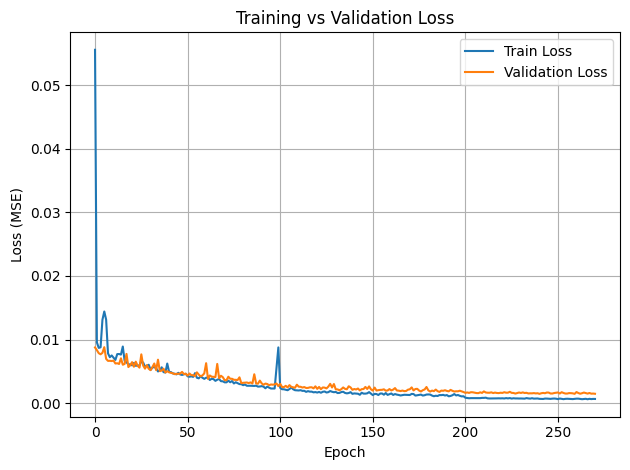

In [9]:
model = StandardVAWTNet(input_dim, airfoil_vocab_size)
train_model_with_logging(
    model,
    train_loader,
    val_loader,
    num_epochs=1000,
    learning_rate=1e-3,
    log_file='training_log.csv',
    patience=30
)

In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['num_features']
            airfoil_types = batch['airfoil_type']
            targets = batch['target']
            outputs = model(inputs, airfoil_types)
            y_true.append(targets.numpy())
            y_pred.append(outputs.numpy())
    y_true = np.vstack(y_true).flatten()
    y_pred = np.vstack(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R²: {r2:.6f}")
    return mae, mse, rmse, r2

In [12]:
evaluate_model(model, test_loader)

MAE: 0.023050, MSE: 0.001311, RMSE: 0.036204, R²: 0.905445


(0.023049702867865562,
 0.001310709398239851,
 np.float64(0.036203720778945514),
 0.9054454565048218)